# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. Portfolios Cleaning and EDA

In [2]:
def offer_mapper(df, column_name):
    coded_dict = dict()
    counter = 0
    offer_encoded = []
    
    for val in df[column_name]:
        if val not in coded_dict:
            coded_dict[val] = counter
            counter+=1
        
        offer_encoded.append(coded_dict[val])
    return offer_encoded

In [3]:
def clean_portfolio_data(df):
    """
    """
    #Rename 'id' column to be more specific in case we need to merge
    df.rename(mapper={'id': 'offer_id'}, axis=1, inplace=True)
    
    #Split 'channels' column and create dummies/one-hot-codes
    df = pd.concat([df, df.channels.apply(lambda x: str(x).strip("[]").replace("'", '')).str.get_dummies(', ')], axis=1)
    df.drop(columns=['channels'], inplace=True)
    
    #Encode offer id from 0 to 9
    df.offer_id = offer_mapper(df, 'offer_id')
    
    #Rearrange columns
    columns_list = df.columns.tolist()
    columns_list = columns_list[2:4] + columns_list[:2] + columns_list[4:]
    df = df[columns_list]
    
    #Index
    df = df.set_index('offer_id')
    
    return df

#### Portfolio dataframe before cleaning

In [4]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


#### Portfolio dataframe after cleaning

In [5]:
portfolio = clean_portfolio_data(portfolio)
portfolio.head(10)

,offer_type,difficulty,duration,reward,email,mobile,social,web
offer_id,,,,,,,,
0,bogo,10,7,10,1,1,1,0
1,bogo,10,5,10,1,1,1,1
2,informational,0,4,0,1,1,0,1
3,bogo,5,7,5,1,1,0,1
4,discount,20,10,5,1,0,0,1
5,discount,7,7,3,1,1,1,1
6,discount,10,10,2,1,1,1,1
7,informational,0,3,0,1,1,1,0
8,bogo,5,5,5,1,1,1,1


#### Discount Type promotions are the least offered at 20%

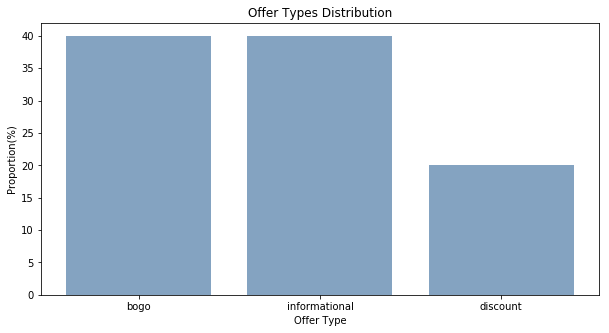

In [6]:
plt.figure(figsize=(10, 5))
plt.bar(x=portfolio.offer_type.unique(),
        height=(portfolio.offer_type.value_counts()/portfolio.shape[0]).values*100,
        color=(0.2, 0.4, 0.6, 0.6))
plt.title('Offer Types Distribution')
plt.xlabel('Offer Type')
plt.ylabel('Proportion(%)');

#### All offers are provided by emails, as long as at least one more channel

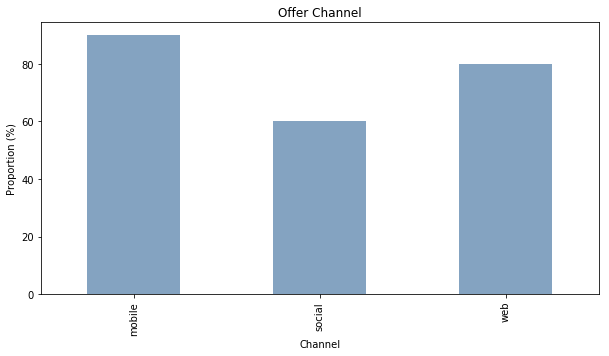

In [7]:
plt.figure(figsize=(10, 5))
(portfolio.iloc[:, 5:].sum()/portfolio.shape[0]*100).plot(kind='bar', color=(0.2, 0.4, 0.6, 0.6))
plt.title('Offer Channel')
plt.xlabel('Channel')
plt.ylabel('Proportion (%)')
plt.show()

#### It can be seen that there is no direct relation between the difficulty of an offer and the reward

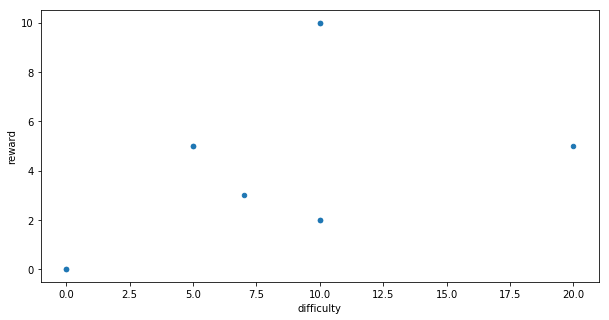

In [8]:
portfolio.plot(x='difficulty', y='reward', kind='scatter', figsize=[10,5]);

#### It can also be seen that there is no direct relation between the duration of an offer and the reward

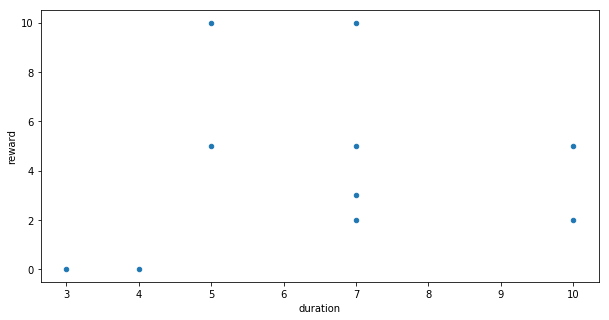

In [9]:
portfolio.plot(x='duration', y='reward', kind='scatter', figsize=[10,5]);

## 2. Profiles cleaning and EDA

In [38]:
def create_age_ranges(df):
    ranges = {'10-19': 0,
              '20-29': 0,
              '30-39': 0,
              '40-49': 0,
              '50-59': 0,
              '60-69': 0,
              '70-79': 0,
              '80-89': 0,
              '90-99': 0,
              '100-109': 0}
    for age in df.age.values:
        ranges['{}-{}'.format(age - age%10, age-age%10+9)] += 1
    
    return ranges

In [10]:
def customer_mapper(df, column_name):
    coded_dict = dict()
    counter = 0
    customer_encoded = []
    
    for val in df[column_name]:
        if val not in coded_dict:
            coded_dict[val] = counter
            counter+=1
        
        customer_encoded.append(coded_dict[val])
    return customer_encoded, coded_dict

In [11]:
def clean_profile_data(df):
    # Dropping rows with NaN values
    df.dropna(inplace=True)
    
    # Convert became_member_on to date
    df.became_member_on = profile.became_member_on.apply(
        lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d'))
    df.became_member_on = pd.to_datetime(profile.became_member_on)
    
    # Sort by date
    df = df.sort_values(['became_member_on', 'income'], ascending=False)
    
    # Encode user id to user_id
    df['customer_id'], customer_dict = customer_mapper(df, 'id')
    df.drop(columns=['id'], inplace=True)
    
    # Index
    df =  df.set_index('customer_id')
    
    return df, customer_dict

In [12]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


#### There happens to be NaN rows as well as people with an age of 118, and they happen to occur simaltaneously

In [13]:
# Apparently some users can opt out from sharing gender and income which happens to be the case here
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [14]:
profile, customer_dict = clean_profile_data(profile)
profile.head()

,age,became_member_on,gender,income
customer_id,,,,
0,76,2018-07-26,M,92000.0
1,59,2018-07-26,F,88000.0
2,63,2018-07-26,M,78000.0
3,46,2018-07-26,M,74000.0
4,77,2018-07-26,F,74000.0


#### Income and Age Analysis

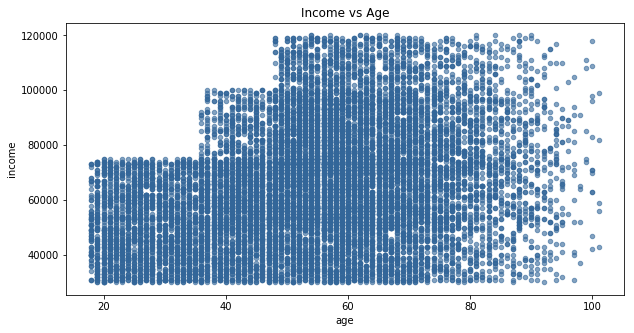

In [16]:
profile.plot(x='age', y='income', title='Income vs Age', kind='scatter', figsize=[10,5], color=(0.2, 0.4, 0.6, 0.6));

In [17]:
print('Average Age: {} \nAverage Income: {}'.format(profile.age.mean(), profile.income.mean()))

Average Age: 54.39352445193929 
Average Income: 65404.9915682968


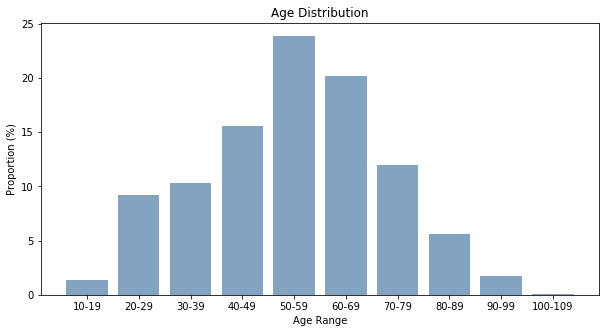

In [52]:
age_data = create_age_ranges(profile)
plt.figure(figsize=(10, 5))
plt.bar(age_data.keys(), height=np.array(list(age_data.values()))/profile.shape[0]*100, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Age Distribution')
plt.ylabel('Proportion (%)')
plt.xlabel('Age Range');

#### Gender Analysis


Text(0, 0.5, 'Proportion (%)')

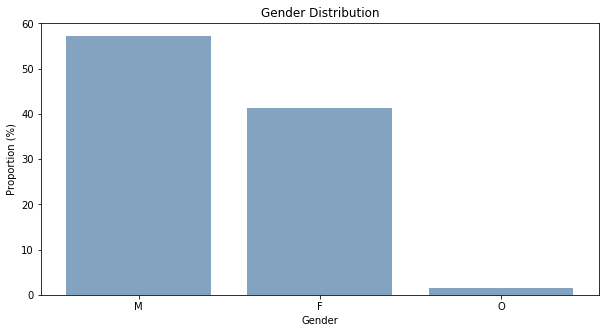

In [66]:
plt.figure(figsize=[10,5])
plt.bar(profile.gender.unique(), profile.gender.value_counts().values/profile.shape[0]*100, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Proportion (%)')